# TimesFM with Covariates

This toturial notebook demonstrates how to utilize exogenous covariates with TimesFM when making forecasts. Before running this notebook, make sure:

- You've read through the README of TimesFM.
- A local kernel with Python 3.10 is up and running, for the jax version.
- Install the JAX version following the installation instructions.

## Setup the environment and install TimesFM.

## Load the checkpoint

**Notice:** Please set up the backend as per your machine ("cpu", "gpu" or "tpu"). This notebook will run by default on GPU.

We load the 2.0-500m model checkpoint from HuggingFace.

In [ ]:
import timesfm
timesfm_backend = "gpu"  # @param

model = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend=timesfm_backend,
          per_core_batch_size=32,
          horizon_len=128,
          num_layers=50,
          use_positional_embedding=False,
          context_len=2048,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )

# Covariates

Let's take a toy example of forecasting sales for a grocery store: 

**Task:** Given the observed the daily sales of this week (7 days), forecast the daily sales of next week (7 days).

```
Product: ice cream
Daily_sales: [30, 30, 4, 5, 7, 8, 10]
Category: food
Base_price: 1.99
Weekday: [0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6]
Has_promotion: [Yes, Yes, No, No, No, Yes, Yes, No, No, No, No, No, No, No]
Daily_temperature: [31.0, 24.3, 19.4, 26.2, 24.6, 30.0, 31.1, 32.4, 30.9, 26.0, 25.0, 27.8, 29.5, 31.2]
```

```
Product: sunscreen
Daily_sales: [5, 7, 12, 13, 5, 6, 10]
Category: skin product
Base_price: 29.99
Weekday: [0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6]
Has_promotion: [No, No, Yes, Yes, No, No, No, Yes, Yes, Yes, Yes, Yes, Yes, Yes]
Daily_temperature: [31.0, 24.3, 19.4, 26.2, 24.6, 30.0, 31.1, 32.4, 30.9, 26.0, 25.0, 27.8, 29.5, 31.2]
```

In this example, besides the `Daily_sales`, we also have covariates `Category`, `Base_price`, `Weekday`, `Has_promotion`, `Daily_temperature`. Let's introduce some concepts:

**Static covariates** are covariates for each time series. 
- In our example, `Category` is a **static categorical covariate**, 
- `Base_price` is a **static numerical covariates**.

**Dynamic covariates** are covaraites for each time stamps.
- Date / time related features can be usually treated as dynamic covariates.
- In our example, `Weekday` and `Has_promotion` are **dynamic categorical covariates**.
- `Daily_temperate` is a **dynamic numerical covariate**.

**Notice:** Here we make it mandatory that the dynamic covariates need to cover both the forecasting context and horizon. For example, all dynamic covariates in the example have 14 values: the first 7 correspond to the observed 7 days, and the last 7 correspond to the next 7 days.

# TimesFM with Covariates


The strategy we take here is to treat covariates as batched in-context exogenous regressors (XReg) and fit linear models on them outside of TimesFM. The final forecast will be the sum of the TimesFM forecast and the linear model forecast.

 In simple words, we consider these two options.

**Option 1:** Get the TimesFM forecast, and fit the linear model regressing the residuals on the covariates ("timesfm + xreg").

**Option 2:** Fit the linear model of the time series itself on the covariates, then forecast the residuals using TimesFM  ("xreg + timesfm").

Let's take a code at the example of Electricity Price Forecasting (EPF). 


In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict

In [ ]:
# df = pd.read_csv('https://datasets-nixtla.s3.amazonaws.com/EPF_FR_BE.csv')
df = pd.read_csv('raw_day_data.csv')
df['onset_date'] = pd.to_datetime(df['onset_date'],format='%Y-%m-%d')
df

This dataset has a few covariates beside the hourly target `y`:

- `unique_id`: a static categorical covariate indicating the country.
- `gen_forecast`: a dynamic numerical covariate indicating the estimated electricity to be generated.
- `system_load`: the observed system load. Notice that this **CANNOT** be considered as a dynamic numerical covariate because we cannot know its values over the forecasting horizon in advance.
- `weekday`: a dynamic categorical covariate.\

Let's now make some forecasting tasks for TimesFM based on this dataset. For simplicity we create forecast contexts of 120 time points (hours) and forecast horizons of 24 time points.

In [ ]:
counties = df['county'].unique()
diseases = df['disease'].unique()
df_counties = pd.read_csv('df_counties.csv')

In [ ]:
# Data pipelining
def get_batched_data_fn(
    disease: str,
    county: str,
    batch_size: int = 128, 
    context_len: int = 365, 
    horizon_len: int = 7,
):
  examples = defaultdict(list)
  if county is not None:
    counties_ = [county]
  else:
    counties_ = counties.copy()
  num_examples = 0
  for county in counties_:
    sub_df = df[(df["disease"] == disease) & (df["county"] == county)]
    for start in range(0, len(sub_df) - (context_len + horizon_len), horizon_len):
      num_examples += 1
      examples["disease"].append(disease)
      examples["county"].append(county)
      examples['long'].append(df_counties[df_counties['county'] == county]['long'].values[0])
      examples['lat'].append(df_counties[df_counties['county'] == county]['lat'].values[0])
      examples["inputs"].append(sub_df["value"][start:(context_end := start + context_len)].tolist())
      examples["last_7_days"].append(sub_df["last_7_days"][start:context_end + horizon_len].tolist())
      examples["last_7_days_neighbor"].append(sub_df["last_7_days_neighbor"][start:context_end + horizon_len].tolist())
      examples["outputs"].append(sub_df["value"][context_end:(context_end + horizon_len)].tolist())
  
  def data_fn():
    for i in range(1 + (num_examples - 1) // batch_size):
      yield {k: v[(i * batch_size) : ((i + 1) * batch_size)] for k, v in examples.items()}
  
  return data_fn


In [ ]:
# Define metrics
def mse(y_pred, y_true):
  y_pred = np.array(y_pred)
  y_true = np.array(y_true)
  return np.mean(np.square(y_pred - y_true), axis=1, keepdims=True)

def mae(y_pred, y_true):
  y_pred = np.array(y_pred)
  y_true = np.array(y_true)
  return np.mean(np.abs(y_pred - y_true), axis=1, keepdims=True)


Now let's try `model.forecast_with_covariates`. 

In particular, the output is a tuple whose first element is the new forecast.

In [ ]:
import time
from tqdm.notebook import tqdm

# Benchmark
batch_size = 128
context_len = 365
horizon_len = 7

metrics_mean = defaultdict(list)
for disease in tqdm(diseases):
  input_data = get_batched_data_fn(disease, None, batch_size, context_len, horizon_len)
  metrics = defaultdict(list)

  for i, example in enumerate(input_data()):
    raw_forecast, _ = model.forecast(
        inputs=example["inputs"], freq=[0] * len(example["inputs"])
    )
    start_time = time.time()
    # Forecast with covariates
    # Output: new forecast, forecast by the xreg
    cov_forecast, ols_forecast = model.forecast_with_covariates(  
        inputs=example["inputs"],
        dynamic_numerical_covariates={
            'last_7_days': example['last_7_days'],
            'last_7_days_neighbor': example['last_7_days_neighbor'],
        },
        dynamic_categorical_covariates={
            
        },
        static_numerical_covariates={
          'long': example['long'],
          'lat': example['lat']
        },
        static_categorical_covariates={
          "disease": example['disease'],
          "county": example["county"]
        },
        freq=[0] * len(example["inputs"]),
        xreg_mode="xreg + timesfm",              # default
        ridge=0.0,
        force_on_cpu=False,
        normalize_xreg_target_per_input=True,    # default
    )
    print(
        f"\rFinished batch {i} linear in {time.time() - start_time} seconds",
        end="",
    )
    metrics["eval_mae_timesfm"].extend(
        mae(raw_forecast[:, :horizon_len], example["outputs"])
    )
    metrics["eval_mae_xreg_timesfm"].extend(mae(cov_forecast, example["outputs"]))
    metrics["eval_mae_xreg"].extend(mae(ols_forecast, example["outputs"]))
    metrics["eval_mse_timesfm"].extend(
        mse(raw_forecast[:, :horizon_len], example["outputs"])
    )
    metrics["eval_mse_xreg_timesfm"].extend(mse(cov_forecast, example["outputs"]))
    metrics["eval_mse_xreg"].extend(mse(ols_forecast, example["outputs"]))

  metrics_mean['disease'].append(disease)
  for k, v in metrics.items():
    print(f"{k}: {np.mean(v)}")
    metrics_mean[k].append(np.mean(v))

pd.DataFrame(data=metrics_mean).to_csv('metrics_mean.csv')

# My output:
# Finished batch 875 linear in 0.27478981018066406 seconds
# eval_mae_timesfm: 0.07512708441369645
# eval_mae_xreg_timesfm: 0.07916631111473996
# eval_mae_xreg: 0.14125861948193896
# eval_mse_timesfm: 0.16500590590719252
# eval_mse_xreg_timesfm: 0.12941367672275625
# eval_mse_xreg: 0.24756478278784388

## Test 1
Dataset:
inputs=example["inputs"],
dynamic_numerical_covariates={
    "last_7_days": example["last_7_days"],
    "last_7_days_neighbor": example["last_7_days_neighbor"],
},
dynamic_categorical_covariates={},
static_numerical_covariates={},
static_categorical_covariates={
    "disease": example['disease'],
    "county": example["county"]
},

Parameters:
batch_size = 128
context_len = 365
horizon_len = 7

Output:
eval_mae_timesfm: 0.06956844832217095
eval_mae_xreg_timesfm: 0.07718363275138859
eval_mae_xreg: 0.1458303443643856
eval_mse_timesfm: 0.1238202625763847
eval_mse_xreg_timesfm: 0.11236914567374198
eval_mse_xreg: 0.2572237269098843


## Test 2
Dataset:
inputs=example["inputs"],
dynamic_numerical_covariates={
    "last_7_days": example["last_7_days"],
    "last_7_days_neighbor": example["last_7_days_neighbor"],
},
dynamic_categorical_covariates={},
static_numerical_covariates={
    'long': example['long'],
    'lat': example['lat']
},
static_categorical_covariates={
    "disease": example['disease'],
    "county": example["county"]
},

Parameters:
batch_size = 128
context_len = 365
horizon_len = 7

Output:
eval_mae_timesfm: 0.06956844832217095
eval_mae_xreg_timesfm: 0.07717677639131347
eval_mae_xreg: 0.14582863765527584
eval_mse_timesfm: 0.1238202625763847
eval_mse_xreg_timesfm: 0.11228735641782281
eval_mse_xreg: 0.25722949054472055


You should see results close to 
```
eval_mae_timesfm: 6.729583250571446
eval_mae_xreg_timesfm: 5.3375301110158
eval_mae_xreg: 37.152760709266
eval_mse_timesfm: 162.3132151851567
eval_mse_xreg_timesfm: 120.9900627409689
eval_mse_xreg: 1672.208769045399
```

With the covariates, the TimesFM forecast Mean Absolute Error improves from 6.73 to 5.34, and Mean Squred Error from 162.31 to 120.99. The results of purely fitting the linear model are also provided for reference.

## Formatting Your Request

It is quite crucial to get the covariates properly formatted so that we can call this `model.forecast_with_covariates`. Please see its docstring for details. Here let's also grab a batch from a toy data input pipeline for quick explanations.

In [ ]:
toy_input_pipeline = get_batched_data_fn(batch_size=2, context_len=5, horizon_len=2)
print(next(toy_input_pipeline()))


You should see something similar to this
```
{
    'country': ['FR', 'FR'], 
    'inputs': [[53.48, 51.93, 48.76, 42.27, 38.41], [48.76, 42.27, 38.41, 35.72, 32.66]], 
    'gen_forecast': [[76905.0, 75492.0, 74394.0, 72639.0, 69347.0, 67960.0, 67564.0], [74394.0, 72639.0, 69347.0, 67960.0, 67564.0, 67277.0, 67019.0]], 
    'week_day': [[3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 3]], 
    'outputs': [[35.72, 32.66], [32.83, 30.06]],
}
```

Notice:
- We have two examples in this batch.
- For each example we support different context lengths and horizon lengths just as `model.forecast`. Although it is not demonstrated in this dataset.
- If dynamic covariates are present, the horizon lengths will be inferred from them, e.g. how many values are provided in additional to the ones corresponding to the inputs. Make sure all your dynamic covariates have the same length per example.
- The static covariates are one per example.



## More Applications

### Past Dynamic Covariates

Past dynamic covariates are covariates that are only available for the context. For instance in our example `system_load` is a past dynamic covariate. Time series models generally can handle this, however it is something the batched in context regression cannot address, because these regressors are not available in the future. If you do have those covariates and consider them very meaningful, there are two hacky options to try immediately:

1. Shift and repeat these past dynamic covariates to use their delayed version. For example, if you think the `system_load` for this week is meaningful for forecasting next week, you can create a `delay_7_system_load` by shifting 7 timestamps and use this as one dynamic numerical covariate for TimesFM.
2. Bootstrap, that is to run TimesFM once to forecast these past dynamic covariates into the horizon, then call TimesFM again using these forecasts as the future part for these dynamic covariates.

### Multivariate Time Series

For multivariate time series, if we need univariate forecast, we can try treating the main time series as the target and use the rest as the dynamic covariates.

In [ ]:
import time

batch_size = 128
context_len = 365
horizon_len = 7
input_data = get_batched_data_fn('手足口', '城阳区' , batch_size, context_len, horizon_len)
y_pred_timesfm = []
y_pred_xreg_timesfm = []
y_pred_xreg = []
y_true = []

for i, example in enumerate(input_data()):
  raw_forecast, _ = model.forecast(
      inputs=example["inputs"], freq=[0] * len(example["inputs"])
  )
  start_time = time.time()
  # Forecast with covariates
  # Output: new forecast, forecast by the xreg
  cov_forecast, ols_forecast = model.forecast_with_covariates(  
      inputs=example["inputs"],
      dynamic_numerical_covariates={
          'last_7_days': example['last_7_days'],
          'last_7_days_neighbor': example['last_7_days_neighbor'],
      },
      dynamic_categorical_covariates={
          
      },
      static_numerical_covariates={
        'long': example['long'],
        'lat': example['lat']
      },
      static_categorical_covariates={
        "disease": example['disease'],
        "county": example["county"]
      },
      freq=[0] * len(example["inputs"]),
      xreg_mode="xreg + timesfm",              # default
      ridge=0.0,
      force_on_cpu=False,
      normalize_xreg_target_per_input=True,    # default
  )
  print(
      f"\rFinished batch {i} linear in {time.time() - start_time} seconds",
      end="",
  )
  y_pred_timesfm.extend(raw_forecast[:, :horizon_len])
  y_pred_xreg_timesfm.extend(cov_forecast)
  y_pred_xreg.extend(ols_forecast)
  y_true.extend(example["outputs"])



Finished batch 2 linear in 0.16433286666870117 seconds

mae_y_pred_timesfm: [[0.87804083]]
mae_y_pred_xreg_timesfm: [[0.79453737]]
mae_y_pred_xreg: [[1.85645523]]
mse_y_pred_timesfm: [[4.32271397]]
mse_y_pred_xreg_timesfm: [[3.08710577]]
mse_y_pred_xreg: [[24.7973827]]


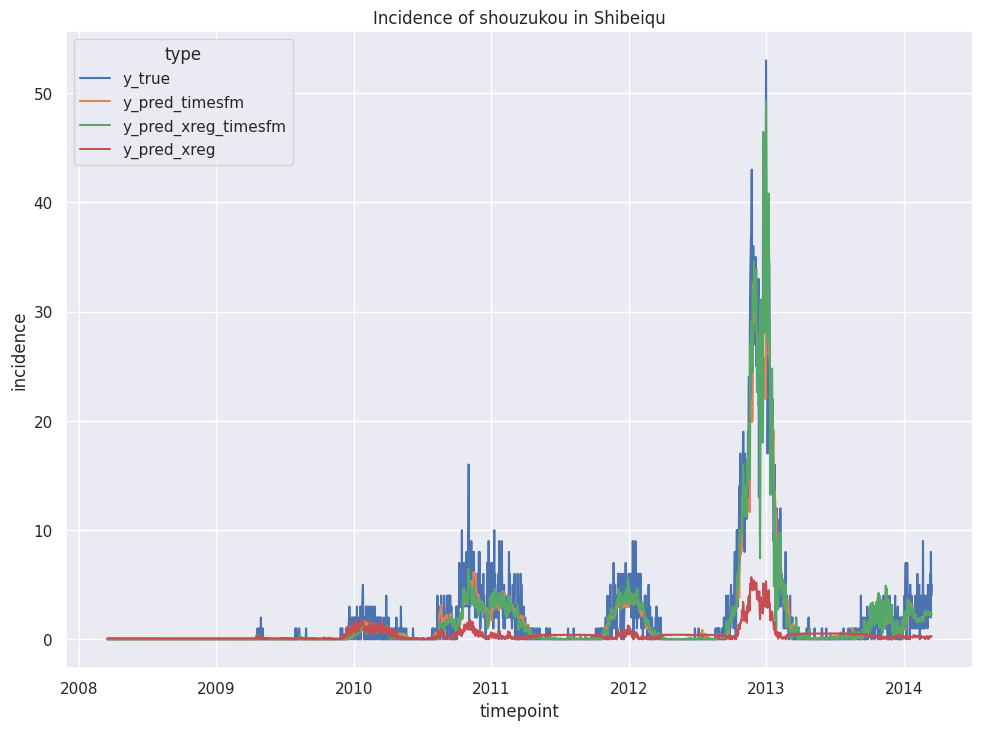

In [ ]:
import seaborn as sns
import math
sns.set_theme(style="darkgrid")

# Load an example dataset with long-form data
y_true = np.reshape(y_true, (1, -1)).ravel()
y_pred_timesfm = np.reshape(y_pred_timesfm, (1, -1)).ravel()
y_pred_xreg_timesfm = np.reshape(y_pred_xreg_timesfm, (1, -1)).ravel()
y_pred_xreg = np.reshape(y_pred_xreg, (1, -1)).ravel()

y_pred_timesfm = abs(y_pred_timesfm)
y_pred_xreg_timesfm = abs(y_pred_xreg_timesfm)
y_pred_xreg = abs(y_pred_xreg)

n = y_true.shape[0]

plot_data = {
    'timepoint': np.concatenate([pd.date_range(start=df['onset_date'].min()+pd.Timedelta(days=365),end=df['onset_date'].min()+pd.Timedelta(days=365+n-1), freq='D').values]*4),
    'incidence': np.concatenate([y_true, y_pred_timesfm, y_pred_xreg_timesfm, y_pred_xreg],axis=None),
    'type': np.concatenate([['y_true']*n, ['y_pred_timesfm']*n, ['y_pred_xreg_timesfm']*n, ['y_pred_xreg']*n],axis=None),
}
df_plot = pd.DataFrame(plot_data)

# Plot the responses for different events and regions
ax = sns.lineplot(x="timepoint", y="incidence",
             hue="type",
             data=df_plot)
ax.set_title('Incidence of shouzukou in Chenyangqu')

print('mae_y_pred_timesfm:',mae([y_true], [y_pred_timesfm]))
print('mae_y_pred_xreg_timesfm:',mae([y_true], [y_pred_xreg_timesfm]))
print('mae_y_pred_xreg:',mae([y_true], [y_pred_xreg]))

print('mse_y_pred_timesfm:',mse([y_true], [y_pred_timesfm]))
print('mse_y_pred_xreg_timesfm:',mse([y_true], [y_pred_xreg_timesfm]))
print('mse_y_pred_xreg:',mse([y_true], [y_pred_xreg]))


In [38]:
plot_data['timepoint'] =  np.concatenate([pd.date_range(start=df['onset_date'].min()+pd.Timedelta(days=365),end=df['onset_date'].min()+pd.Timedelta(days=365+n-1), freq='D').values]*4)
plot_data['timepoint']

array(['2008-03-17T00:00:00.000000000', '2008-03-18T00:00:00.000000000',
       '2008-03-19T00:00:00.000000000', ...,
       '2014-03-14T00:00:00.000000000', '2014-03-15T00:00:00.000000000',
       '2014-03-16T00:00:00.000000000'],
      shape=(8764,), dtype='datetime64[ns]')

In [50]:

print('mae_y_pred_timesfm:',mae([y_true], [y_pred_timesfm]))
print('mae_y_pred_xreg_timesfm:',mae([y_true], [y_pred_xreg_timesfm]))
print('mae_y_pred_xreg:',mae([y_true], [y_pred_xreg]))

print('mse_y_pred_timesfm:',mse([y_true], [y_pred_timesfm]))
print('mse_y_pred_xreg_timesfm:',mse([y_true], [y_pred_xreg_timesfm]))
print('mse_y_pred_xreg:',mse([y_true], [y_pred_xreg]))

mae_y_pred_timesfm: [[1.12520861]]
mae_y_pred_xreg_timesfm: [[1.14414228]]
mae_y_pred_xreg: [[2.58015856]]
mse_y_pred_timesfm: [[5.18687253]]
mse_y_pred_xreg_timesfm: [[5.48891886]]
mse_y_pred_xreg: [[26.30858]]


In [ ]:
df_day[df_day['disease']=='手足口']